Course: Aprendizaje Automático.

Module: Aprendizaje Supervisado.

Student name: Luis Felipe Castañeda Gallego.

## 1. Introduction

The purpose of this notebook is to create, evaluate and analyze  three classification models to predict the labels or business classes generated in the previous notebook, to which the companies that have won contracts in the bidding processes in the United States during fiscal year 2023.

The following is a list and import of the libraries, classes, and methods used for the development of the current notebook:

In [1]:
# Standard library imports
import numpy as np

# Related third-party imports
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

## 2. Load and read the data

Load the fiscal year 2023 contract labeled data from a CSV file.

In [2]:
df_4 = pd.read_csv("..\\Data\\df_4.csv")

Display the first five rows of df_4.

In [3]:
df_4.head()

,federal_action_sum,recipient_country,recipient_state,state_of_performance,award_type,type_of_contract_pricing,naics,extent_competed,c8a_program,number_of_contracts,km_labels,cluster_label
0,45935.00,united states,ca,ca,purchase order,firm fixed price,337,not competed under sap,f,1,2,C
1,4463.00,united states,dc,dc,bpa call,firm fixed price,541,competed under sap,f,4,0,D
2,171001.76,united states,tx,tx,purchase order,firm fixed price,541,competed under sap,f,3,2,C
3,7515586.92,united states,in,in,delivery order,firm fixed price,311,full and open competition,f,11,1,A
4,1702950.88,united states,nh,co,delivery order,firm fixed price,334,full and open competition,f,3,1,A


Display the structure and column-wise non-null count of the df_4 DataFrame.

In [4]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86145 entries, 0 to 86144
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   federal_action_sum        86145 non-null  float64
 1   recipient_country         86145 non-null  object 
 2   recipient_state           86145 non-null  object 
 3   state_of_performance      86145 non-null  object 
 4   award_type                86145 non-null  object 
 5   type_of_contract_pricing  86145 non-null  object 
 6   naics                     86145 non-null  object 
 7   extent_competed           86145 non-null  object 
 8   c8a_program               86145 non-null  object 
 9   number_of_contracts       86145 non-null  int64  
 10  km_labels                 86145 non-null  int64  
 11  cluster_label             86145 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 7.9+ MB


Remove the unnecesary column km_labels.

In [5]:
df_4.drop(['km_labels'], axis=1, inplace=True)

As the data is clean proced to check for duplicated rows.

In [6]:
duplicates = df_4.duplicated(keep=False)  
num_duplicates = duplicates.sum()
num_duplicates

2026

Select and list all columns in the dataframe df_4 that contain categorical data, identified by their data type being 'object'.

In [7]:
categorical_features = df_4.select_dtypes(include=['object']).columns
categorical_features

Index(['recipient_country', 'recipient_state', 'state_of_performance',
       'award_type', 'type_of_contract_pricing', 'naics', 'extent_competed',
       'c8a_program', 'cluster_label'],
      dtype='object')

Generate a histogram for each categorical feature in the df_4 dataframe.

In [8]:
for variable in categorical_features[:]:
    # Histogram
    countplot_fig = px.histogram(
        df_4,
        x=df_4[variable].value_counts().index,
        y=df_4[variable].value_counts().values,
        title=f'Counting for {variable}',
        )
    countplot_fig.update_traces(texttemplate='%{y}', textposition='outside')
    countplot_fig.update_xaxes(categoryorder='total ascending')
    # Pie chart
    counts = df_4[variable].value_counts()
    labels = counts.index
    pie_chart_fig = px.pie(
        names=labels,
        values=counts,
        title=f'Pie chart for {variable}',
        labels={'names': '', 'values': ''},
        hole=0.3,
        )

    # Show legend
    pie_chart_fig.update_traces(textinfo='percent+label', pull=[0.05]*len(labels))

    # Save and display the plot
    # countplot_fig.write_html(f"{variable}_countplot.html")
    # pie_chart_fig.write_html(f"{variable}_pie_chart.html")
    countplot_fig.show()
    # pie_chart_fig.show()

Select and list all columns in the dataframe df_4 that contain numerical.

In [9]:
numerical_features = df_4[['federal_action_sum', 'number_of_contracts']].columns
numerical_features

Index(['federal_action_sum', 'number_of_contracts'], dtype='object')

Generate a boxplot for each numerical feature in the dataframe df_4.

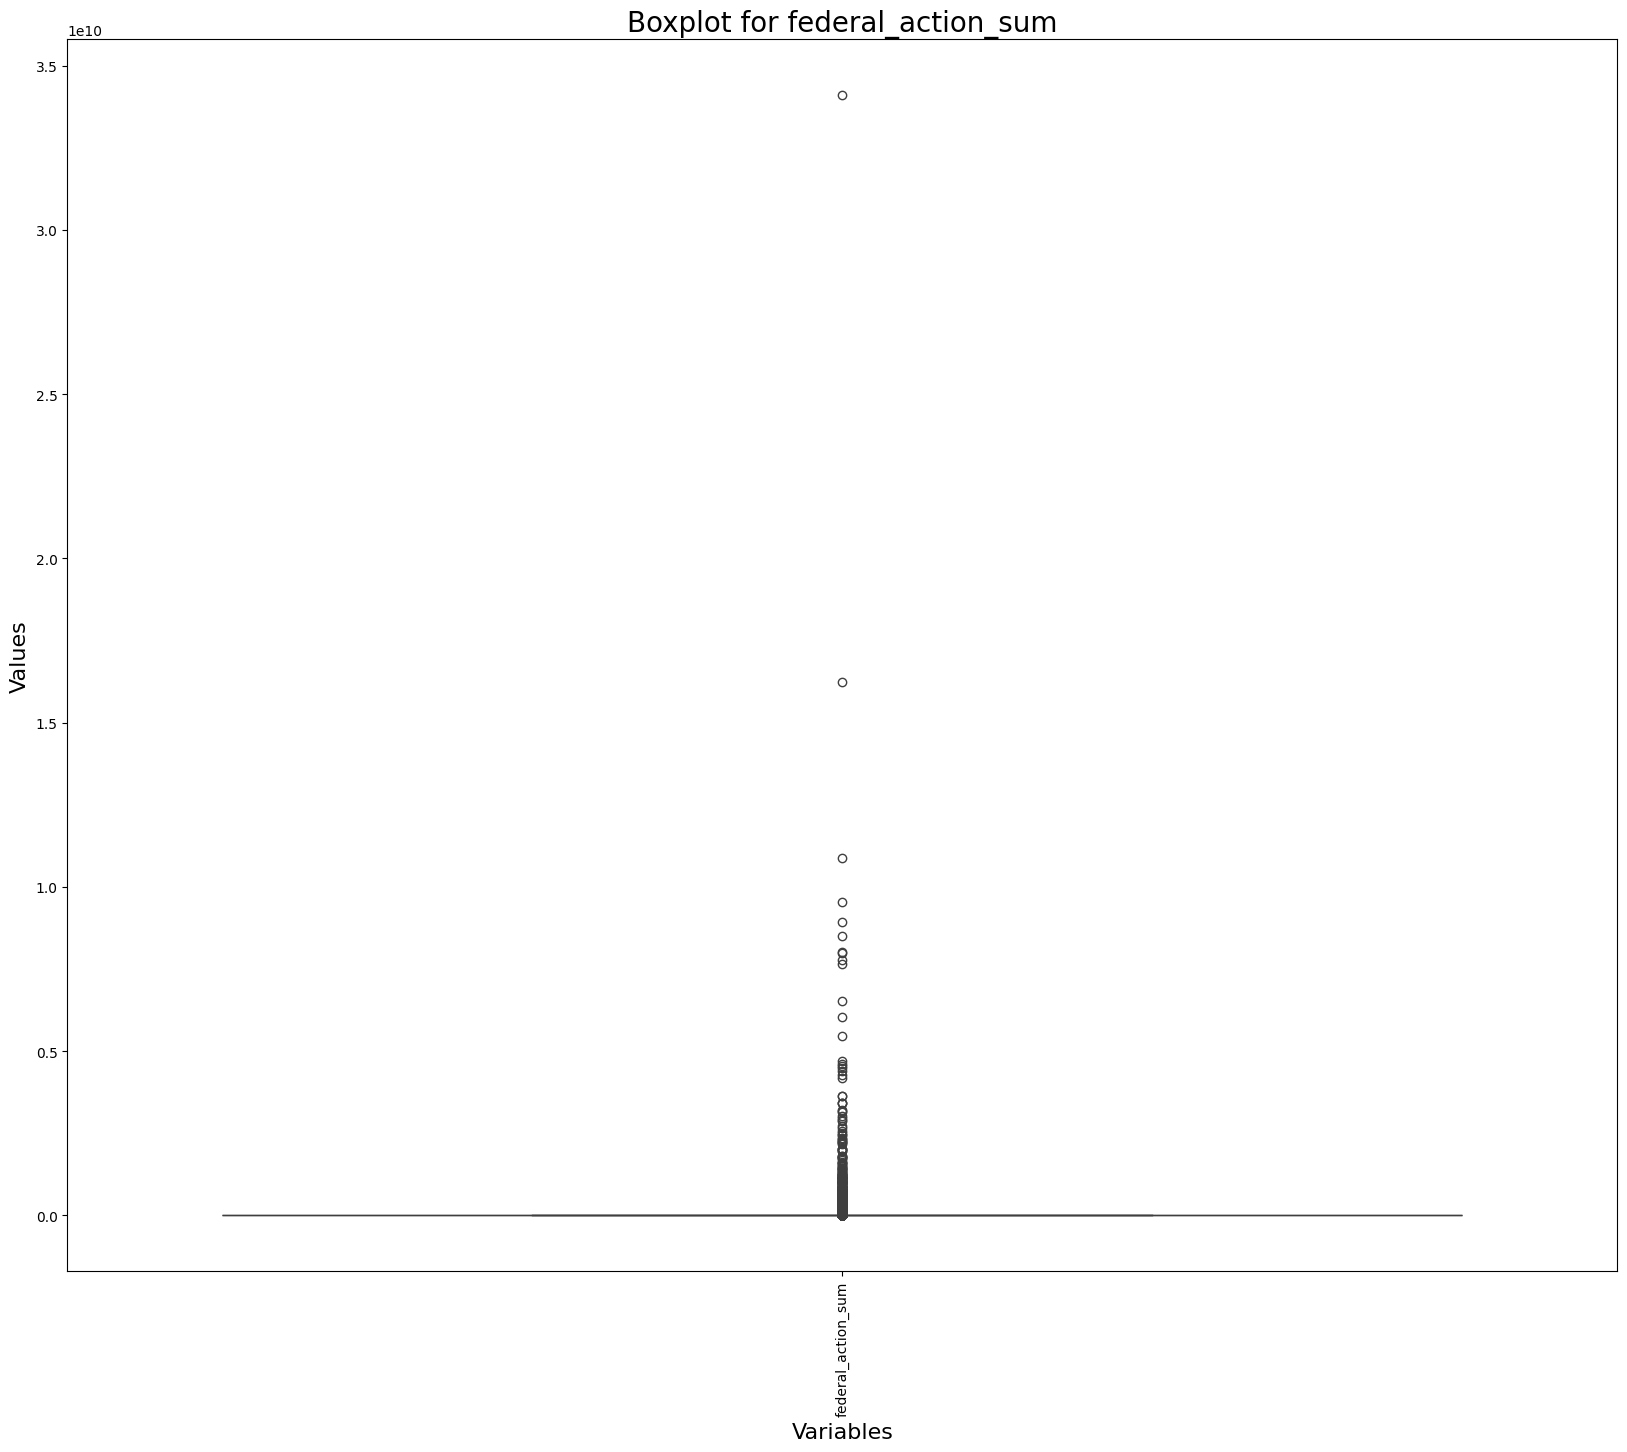

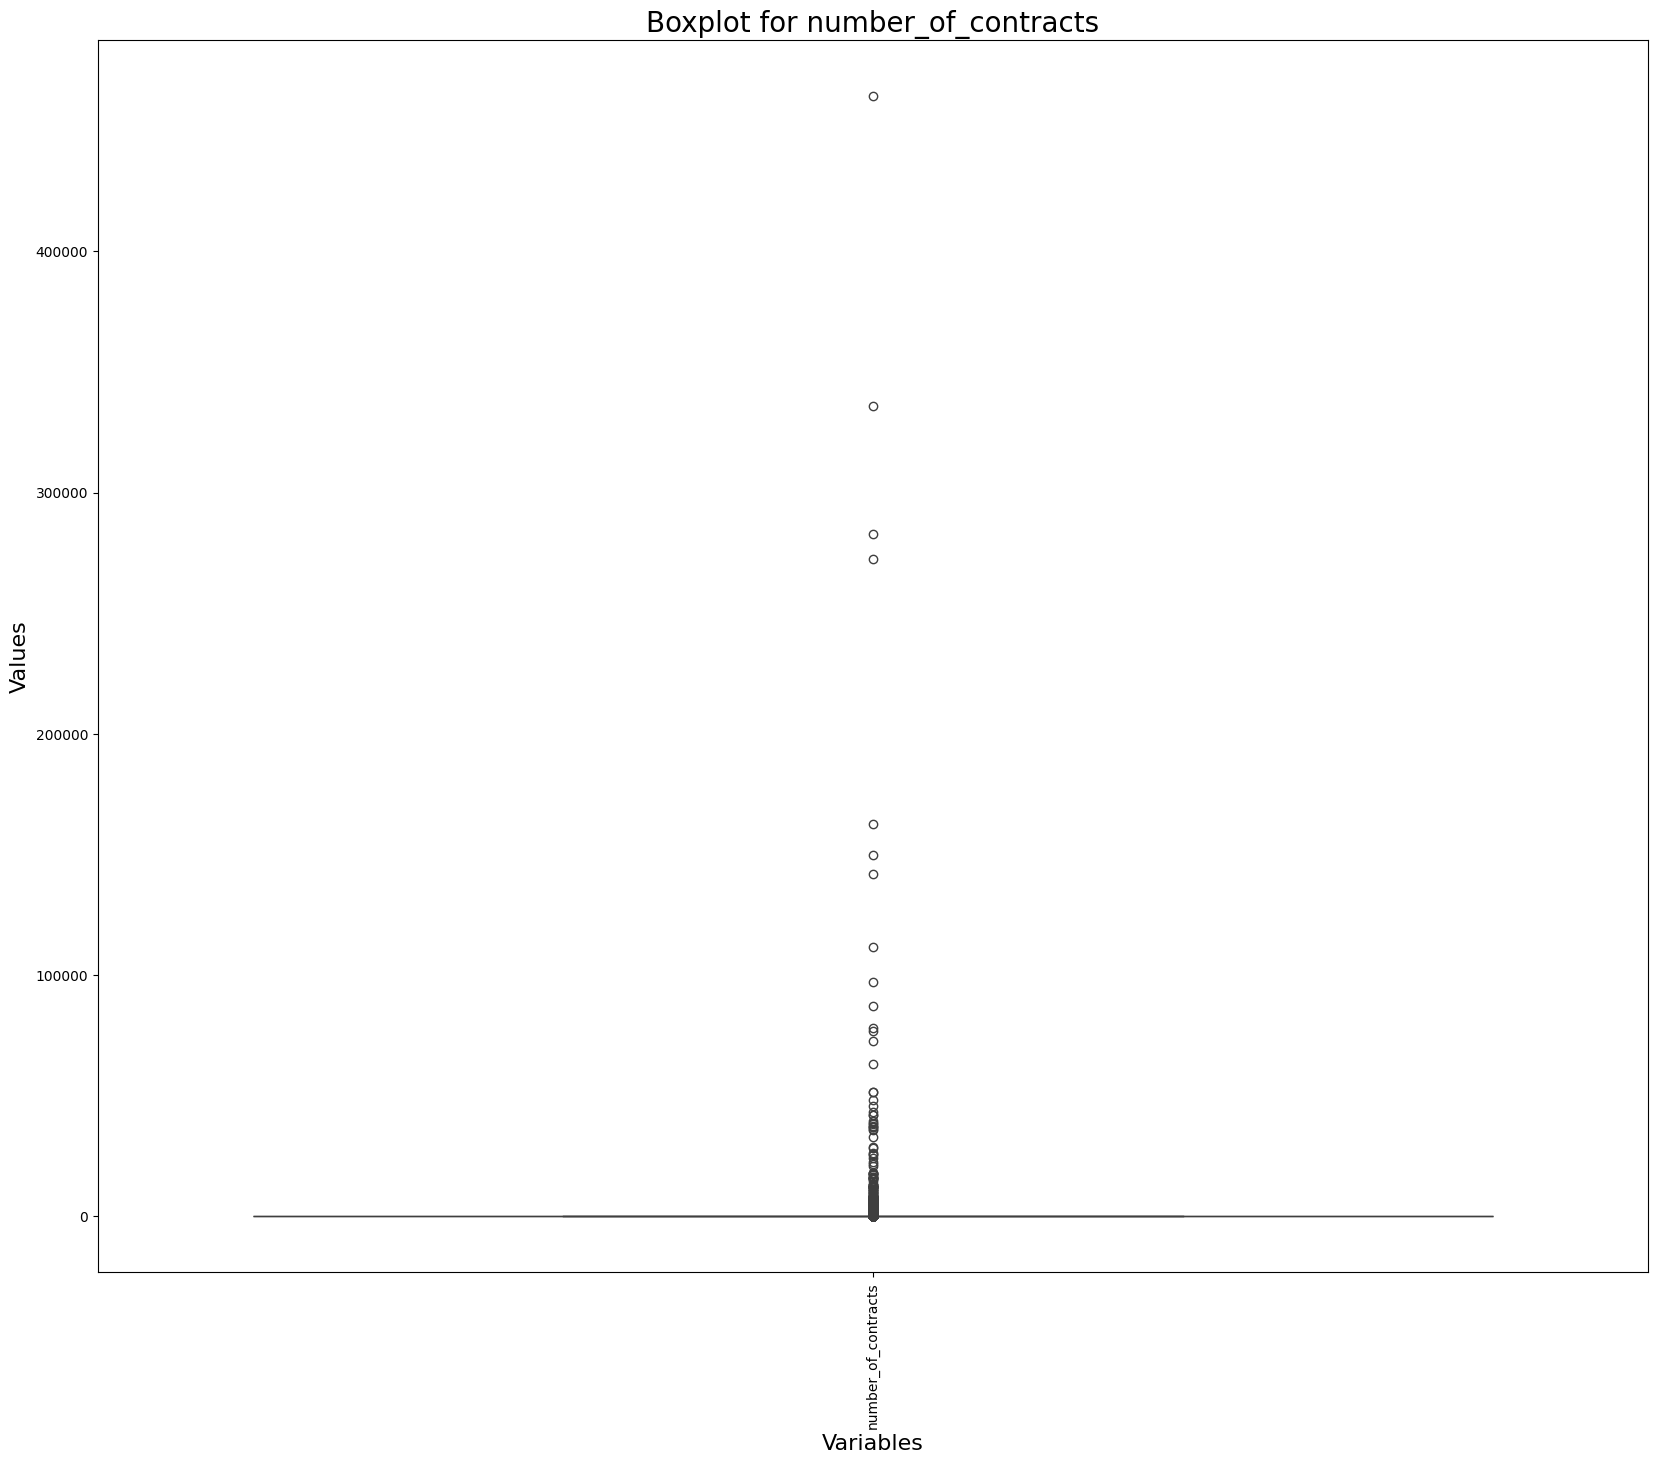

In [10]:
for column in df_4[numerical_features]:
    plt.figure(figsize=(20, 16))
    sns.boxplot(data=df_4[[column]])
    plt.title(f'Boxplot for {column}', fontsize=20)
    plt.xlabel('Variables', fontsize=16)
    plt.ylabel('Values', fontsize=16)
    plt.xticks(rotation=90)
    plt.show()

Generate a distributio for each numerical feature in the dataframe df_4.

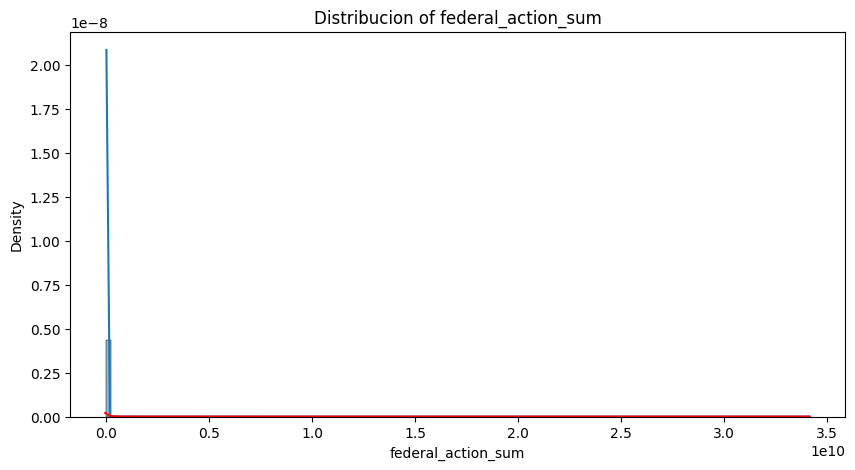

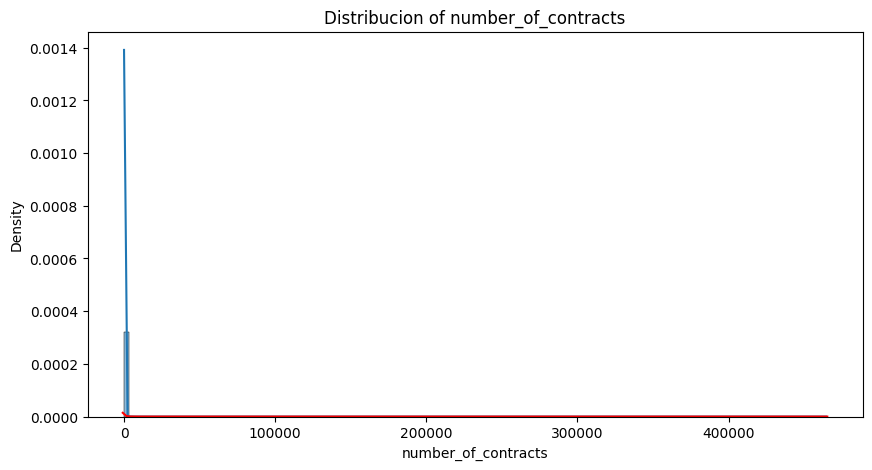

In [11]:
for col in df_4[numerical_features]:
    plt.figure(figsize=(10, 5))
    plt.title(f'Distribucion of {col}')
    sns.histplot(df_4[col], bins=150, kde=True, stat='density')
    sns.kdeplot(df_4[col], color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    # plt.savefig(f'density_{col}_plot.png')
    plt.show()

Conduct a bivariate analysis between the target variable and each numerical feature in a dataframe.

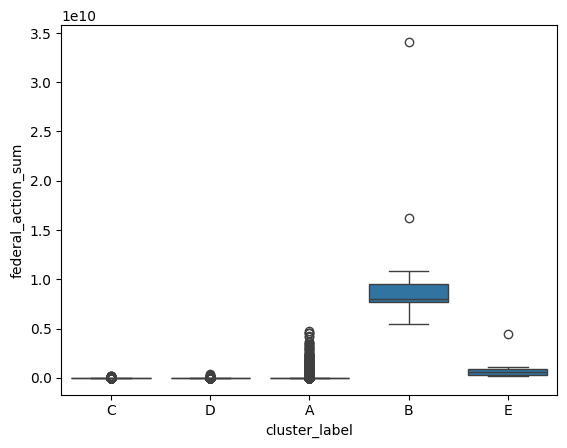

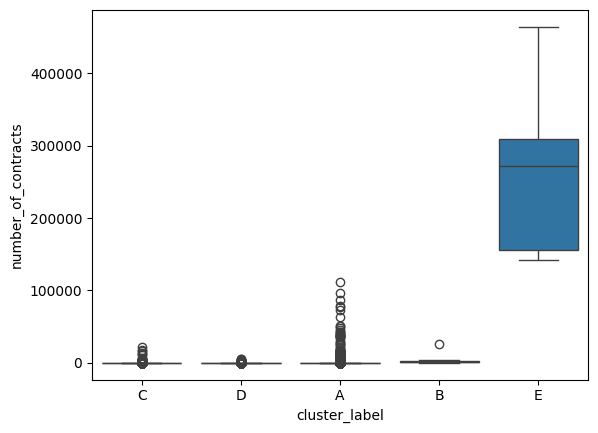

In [12]:
def bivariate_analysis_numerical(df, var_target, var_numerical):
    for col in var_numerical:
        sns.boxplot(x=var_target, y=col, data=df)
        plt.show()

bivariate_analysis_numerical(df_4, 'cluster_label', df_4[numerical_features])

Remove duplicates.

In [13]:
df_4 = df_4.drop_duplicates(keep='first')

Verify changes by checking info again.

In [14]:
duplicates = df_4.duplicated(keep=False)  
num_duplicates = duplicates.sum()
num_duplicates

0

Display the structure and column-wise non-null count of the df_4 DataFrame.

In [15]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84817 entries, 0 to 86144
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   federal_action_sum        84817 non-null  float64
 1   recipient_country         84817 non-null  object 
 2   recipient_state           84817 non-null  object 
 3   state_of_performance      84817 non-null  object 
 4   award_type                84817 non-null  object 
 5   type_of_contract_pricing  84817 non-null  object 
 6   naics                     84817 non-null  object 
 7   extent_competed           84817 non-null  object 
 8   c8a_program               84817 non-null  object 
 9   number_of_contracts       84817 non-null  int64  
 10  cluster_label             84817 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 7.8+ MB


Review the frequency of the classes in the target column.

In [16]:
df_4['cluster_label'].value_counts()

cluster_label
C    43137
A    29646
D    12014
B       13
E        7
Name: count, dtype: int64

Calculate and display the distribution balance of the target feature cluster_label in the dataframe df_4, and visualize this distribution in a pie chart.

In [17]:
balance_ratio = df_4['cluster_label'].value_counts(normalize=True)

print("Grade of balance of the target feature:")
print(balance_ratio)
print("-----------------------------------------")

fig = px.pie(
    df_4,
    values=df_4['cluster_label'].value_counts().values,
    names=df_4['cluster_label'].value_counts().index,
    )
fig.update_traces(textinfo='percent+label', pull=[0.05, 0.05])

fig.update_layout(
    title='Pie Chart - "cluster_label"',
)

fig.show()

Grade of balance of the target feature:
cluster_label
C    0.508589
A    0.349529
D    0.141646
B    0.000153
E    0.000083
Name: proportion, dtype: float64
-----------------------------------------


Create a histogram to visualize the distribution of categories within the 'cluster_label' column of the dataframe df_4.

In [18]:
fig = px.histogram(
    df_4,
    x=df_4['cluster_label'].value_counts().index,
    y=df_4['cluster_label'].value_counts().values,
    title='Balance between classes of the target feaure "cluster_labels"',
    )

fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_xaxes(categoryorder='total ascending')
fig.update_layout(
    xaxis_title='Class',
    yaxis_title='Quantity',
    showlegend=False
)
fig.show()

Duplicate the DataFrame df_4 to df_5.

## 3. Processing the data

In [19]:
df_5 = df_4.copy()

### 3.1. Balance the data

Calculate the distribution of the cluster_label categories within the dataframe df_5 and identify the maximum size among the categories.

In [20]:
class_distribution = df_5['cluster_label'].value_counts()
max_size = class_distribution.max()

Perform class balancing on the dataframe df_5 by resampling smaller classes to match the size of the largest class.

In [21]:
resampled_dfs = {}

for class_index, group in df_5.groupby('cluster_label'):
    if group.shape[0] < max_size:
        resampled_dfs[class_index] = resample(group,
                                              replace=True,
                                              n_samples=max_size,
                                              random_state=42)
    else:
        resampled_dfs[class_index] = group

df_5_balanced = pd.concat(resampled_dfs.values(), ignore_index=True)

Calculate and print the distribution of the cluster_label categories in the newly balanced dataframe df_5_balanced.

In [22]:
new_class_distribution = df_5_balanced['cluster_label'].value_counts()
print(new_class_distribution)

cluster_label
A    43137
B    43137
C    43137
D    43137
E    43137
Name: count, dtype: int64


Display the first five rows of df_5_balanced.

In [23]:
df_5_balanced.head()

,federal_action_sum,recipient_country,recipient_state,state_of_performance,award_type,type_of_contract_pricing,naics,extent_competed,c8a_program,number_of_contracts,cluster_label
0,2.310000e+05,united states,dc,dc,definitive contract,labor hours,541,full and open competition,f,1,A
1,1.256636e+05,united states,tn,ms,definitive contract,firm fixed price,541,not competed,f,1,A
2,1.213001e+07,united states,oh,oh,definitive contract,firm fixed price,541,full and open competition after exclusion of s...,f,22,A
3,3.618271e+09,united states,ca,ca,definitive contract,cost plus fixed fee,524,full and open competition,f,76,A
4,1.346340e+05,united states,ky,ky,definitive contract,firm fixed price,238,not competed,f,3,A


Output a column-wise count of non-null values of df_5_balanced.

In [24]:
df_5_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215685 entries, 0 to 215684
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   federal_action_sum        215685 non-null  float64
 1   recipient_country         215685 non-null  object 
 2   recipient_state           215685 non-null  object 
 3   state_of_performance      215685 non-null  object 
 4   award_type                215685 non-null  object 
 5   type_of_contract_pricing  215685 non-null  object 
 6   naics                     215685 non-null  object 
 7   extent_competed           215685 non-null  object 
 8   c8a_program               215685 non-null  object 
 9   number_of_contracts       215685 non-null  int64  
 10  cluster_label             215685 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 18.1+ MB


Duplicate the cleaned DataFrame df_5 to df_6.

In [26]:
df_6 = df_5_balanced.copy()

In [27]:
df_6.columns

Index(['federal_action_sum', 'recipient_country', 'recipient_state',
       'state_of_performance', 'award_type', 'type_of_contract_pricing',
       'naics', 'extent_competed', 'c8a_program', 'number_of_contracts',
       'cluster_label'],
      dtype='object')

### 3.2. Split the data into training and test sets

Split the dataset into training and test sets.

In [28]:
X = df_6.drop('cluster_label', axis=1)
y = df_6['cluster_label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    )

### 3.3. Create the pipeline for the classification models

Identify and separate the names of categorical and numerical columns from the training dataset X_train.

In [29]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

Create transformers for numerical and categorical data.

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ])

Define the model pipeline.

In [31]:
models = {
    'logistic_regression': LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
}

In [32]:
param_grid = {
    'logistic_regression': {
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear'],
    },
    'decision_tree': {
        'model__criterion': ['gini', 'entropy'],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [10, 15],
    },
    'random_forest': {
        'model__n_estimators': [100, 150],
        'model__max_depth': [15, 20],
        'model__min_samples_split': [15, 20],
        'model__min_samples_leaf': [4, 8],
    },
}

In [33]:
best_estimators = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    clf = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    
    best_estimators[model_name] = clf.best_estimator_
    print(f"Best params for {model_name}: {clf.best_params_}")
    print(f"Best cross-validated score for {model_name}: {clf.best_score_}")

Best params for logistic_regression: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best cross-validated score for logistic_regression: 0.999880777814344
Best params for decision_tree: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__splitter': 'best'}
Best cross-validated score for decision_tree: 0.999933765184314
Best params for random_forest: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 150}
Best cross-validated score for random_forest: 0.9996025928607162


Predict the test set results, generate the classification report, the confusion matrix and plot the confusion matrix using seaborn for better visualization.

Evaluating model: logistic_regression
Classification Report for logistic_regression:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     12863
           B       1.00      1.00      1.00     12892
           C       1.00      1.00      1.00     13061
           D       1.00      1.00      1.00     12844
           E       1.00      1.00      1.00     13046

    accuracy                           1.00     64706
   macro avg       1.00      1.00      1.00     64706
weighted avg       1.00      1.00      1.00     64706

Confusion Matrix for logistic_regression:
[[12855     3     1     4     0]
 [    0 12892     0     0     0]
 [    0     0 13061     0     0]
 [    1     0     0 12843     0]
 [    0     0     0     0 13046]]


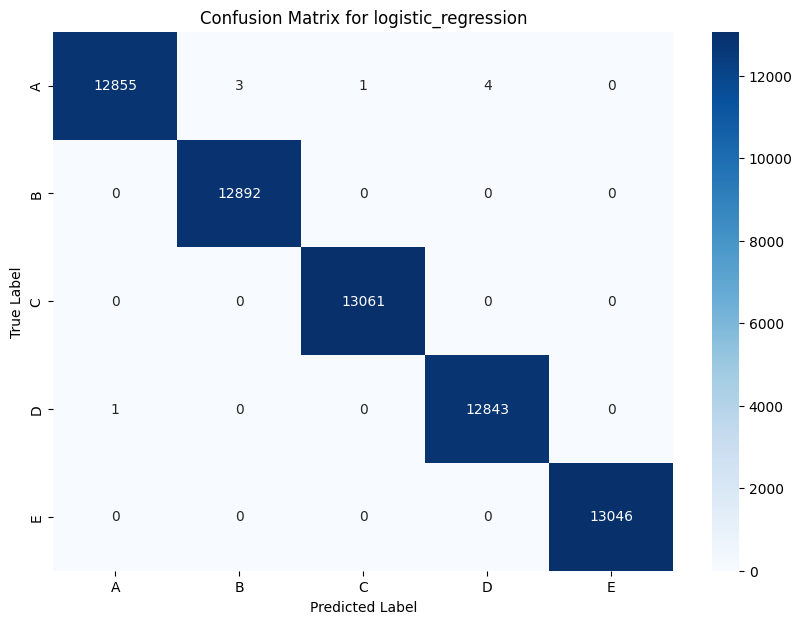

Evaluating model: decision_tree
Classification Report for decision_tree:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     12863
           B       1.00      1.00      1.00     12892
           C       1.00      1.00      1.00     13061
           D       1.00      1.00      1.00     12844
           E       1.00      1.00      1.00     13046

    accuracy                           1.00     64706
   macro avg       1.00      1.00      1.00     64706
weighted avg       1.00      1.00      1.00     64706

Confusion Matrix for decision_tree:
[[12859     0     0     4     0]
 [    0 12892     0     0     0]
 [    0     0 13060     1     0]
 [    3     0     0 12841     0]
 [    0     0     0     0 13046]]


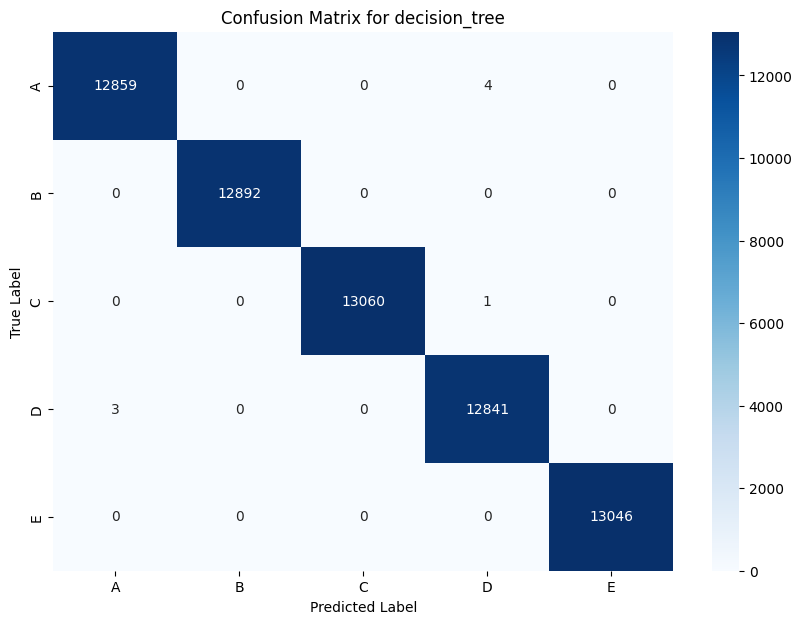

Evaluating model: random_forest
Classification Report for random_forest:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     12863
           B       1.00      1.00      1.00     12892
           C       1.00      1.00      1.00     13061
           D       1.00      1.00      1.00     12844
           E       1.00      1.00      1.00     13046

    accuracy                           1.00     64706
   macro avg       1.00      1.00      1.00     64706
weighted avg       1.00      1.00      1.00     64706

Confusion Matrix for random_forest:
[[12843     0     5    15     0]
 [    0 12892     0     0     0]
 [    0     0 13061     0     0]
 [    0     0     0 12844     0]
 [    0     0     0     0 13046]]


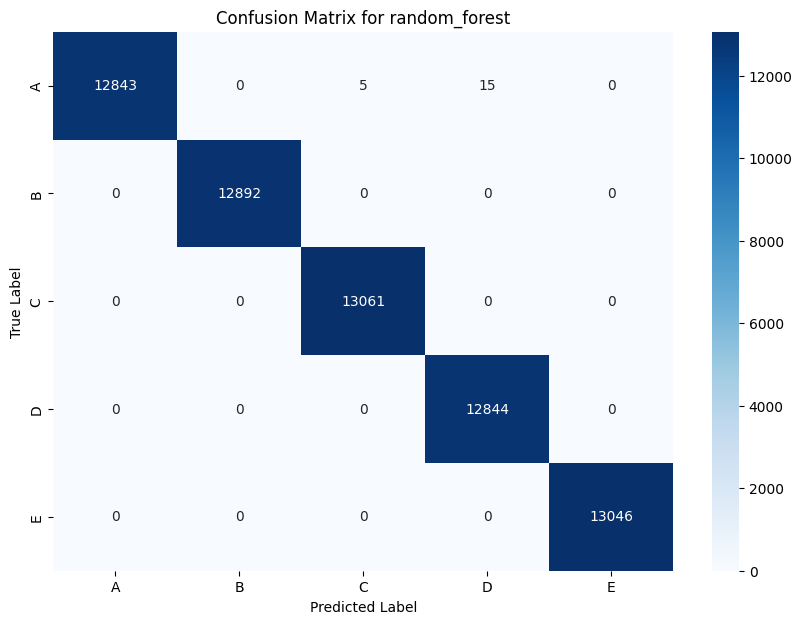

In [34]:
for model_name, model in best_estimators.items():
    print(f"Evaluating model: {model_name}")
    
    y_pred = model.predict(X_test)
    
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name}:")
    print(cm)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## 4. Results analysis


The results for logistic regression, decision tree, and random forest models presents exemplary performance, with precision, recall, f1-scores, and overall accuracy nearing perfection. This section offers a detailed analysis of each model’s strengths and the implications of their respective configurations.

#### **1. Logistic Regression**

- **Best Parameters**: The selection of `C=10`, `penalty=l1`, and `solver=liblinear` implies a model that effectively balances complexity and regularization to maximize predictive accuracy. The `l1` penalty helps in feature selection by zeroing out less important features, which is particularly useful in scenarios with potentially redundant or irrelevant features.
- **Performance Metrics**: With perfect scores across all classes, the logistic regression model demonstrates robustness and high discriminatory power.
- **Confusion Matrix Insight**: The very few misclassifications between classes A and D indicate exceptional model accuracy, with slight confusion between closely related or overlapping features between these classes.

#### **2. Decision Tree**

- **Best Parameters**: The `criterion=entropy`, `max_depth=10`, and `splitter=best` configuration indicates a preference for a model that efficiently handles both the complexity of the data and potential overfitting. The entropy criterion suggests that the model gains the most from splits that maximize information gain.
- **Performance Metrics**: Similarly to logistic regression, the decision tree displays outstanding performance metrics, underscoring its ability to handle complex decision boundaries effectively.
- **Confusion Matrix Insight**: Near-perfect classification with minimal errors mostly concerning class D misclassified as A, pointing to subtle overlaps in data characteristics or feature distributions that are occasionally challenging for the model.

#### **3. Random Forest**

- **Best Parameters**: The configuration with `max_depth=20`, `min_samples_leaf=4`, `min_samples_split=15`, and `n_estimators=150` reflects a strategically complex model that is still restrained enough to avoid overfitting. This setup promotes generalization by enforcing minimum samples criteria while allowing the forest to explore a significant number of trees.
- **Performance Metrics**: Maintains the trend of near-perfect scores, asserting the power of ensemble methods in enhancing predictive accuracy and stability over individual decision trees.
- **Confusion Matrix Insight**: Shows a small number of misclassifications, particularly from class A misclassified as C and D. This suggests that while the random forest effectively aggregates decisions to improve accuracy, slight feature overlaps persist that challenge the model under certain conditions.

- **High Predictive Performance**: All models have demonstrated the capability to achieve almost perfect classification results, which speaks to both the quality of the data and the effectiveness of the model tuning.
- **Model Selection Considerations**: 
  - **Logistic Regression** is advisable for scenarios where model simplicity and interpretability are important alongside performance.
  - **Decision Trees** provide a good balance between performance and interpretability but might require careful monitoring for overfitting despite the controlled depth.
  - **Random Forests** are suited for applications where the highest level of accuracy is needed and computational resources and model complexity are not major constraints.

## 5. Conclusions

Based on the evaluation results of three machine learning models—logistic regression, decision tree, and random forest—on a classification task, the following can be said:

1. **High Performance Across Models**: All three models exhibit exceptionally high performance metrics, with near-perfect precision, recall, and F1-scores for each category (A, B, C, D, E). This suggests that the feature engineering and model tuning have been effectively executed for this specific dataset.

2. **Model Comparison**:
   - **Logistic Regression**: This model shows outstanding performance, with a remarkable cross-validated score of 0.999880777814344. The confusion matrix indicates minimal misclassification, which supports the model’s robustness in handling the dataset.
   - **Decision Tree**: The decision tree model has the highest cross-validated score (0.999933765184314) among the three, indicating extremely reliable predictions. The negligible misclassification errors (mostly in the D class) suggest that the model has effectively captured the underlying patterns without overfitting, which is often a concern with decision trees.
   - **Random Forest**: While the random forest model has a slightly lower cross-validated score (0.9996025928607162) compared to the other two models, it still performs exceptionally well. The few misclassifications between classes A and D could potentially be improved with further hyperparameter tuning or feature selection.

3. **Applicability**:
   - Given the high accuracy and reliability of these models, they can be effectively used in critical decision-making environments where precision is paramount. For example, these models could be employed in financial risk assessment, medical diagnosis systems, or quality control processes in manufacturing.
   - The minimal differences in the misclassification rates among the models suggest that simpler models like logistic regression and decision trees might be preferred due to their ease of interpretation and lower computational cost compared to a more complex model like a random forest.

4. **Recommendations for Deployment**:
   - **Model Selection**: If the computational efficiency and ease of interpretation are key considerations, logistic regression or decision trees might be more suitable. If the problem complexity increases or the dataset becomes noisier, a random forest might provide better generalization.
   - **Monitoring and Maintenance**: Regular monitoring of the model performance should be implemented upon deployment to quickly identify any shifts in data characteristics or performance decay. Continuous retraining using updated data can also help maintain high performance.

5. **Further Investigations**:
   - Exploring other model families (e.g., Support Vector Machines, Neural Networks) might provide insights into whether higher or comparable performance can be achieved with different approaches.
   - Conducting a feature importance analysis, especially for the tree-based models, would help in understanding the driving factors behind the predictions, thus offering valuable insights for feature engineering or domain-specific applications.

These conclusions highlight the effectiveness of machine learning models in high-stakes classification tasks and provide a framework for their real-world application and continuous improvement.